In [1]:
import numpy as np
import pandas as pd
import math
import scipy.stats as stats
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import sklearn
from sklearn import metrics
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

In [2]:
#Data pre-processing
train = pd.read_csv('data/train.csv')
features = pd.read_csv('data/features.csv')
test = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')
# For Output_excel file...
writer=pd.ExcelWriter('Walmart Store Sales Prediction output.xlsx', engine='xlsxwriter')

In [3]:
#Merging the data
dtr = pd.merge(train,stores) 
tr = pd.merge(dtr,features)
dte = pd.merge(test,stores)
te= pd.merge(dte,features)

In [4]:
train.head()          

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [7]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [8]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [9]:
print (tr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB
None


In [10]:
#Training data
num_vt=[k for k in dict(tr.dtypes) if dict(tr.dtypes)[k] in ['float64', 'int64', 'float32', 'int32']]
cat_vt=[k for k in dict(tr.dtypes) if dict(tr.dtypes)[k] in ['object']]
# Train Numerical Data
t_num=tr[num_vt]
# Train Categorical Data
t_cat=tr[cat_vt]
print (num_vt)
print (cat_vt)

['Store', 'Dept', 'Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']
['Date', 'Type']


In [11]:
num_vt=[k for k in dict(te.dtypes) if dict(te.dtypes)[k] in ['float64', 'int64', 'float32', 'int32']]
cat_vt=[k for k in dict(te.dtypes) if dict(te.dtypes)[k] in ['object']]
# Train Numerical Data
t_num=te[num_vt]
# Train Categorical Data
t_cat=te[cat_vt]
print (num_vt)
print (cat_vt)

['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']
['Date', 'Type']


In [12]:
#Correlation
tr_corr=pd.DataFrame(tr.corr())
tr_corr.to_excel(writer,'Train_Data Corr',index=True)
tr_corr.head()

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Store,1.000000,0.024004,-0.085195,-0.000548,-0.182881,-0.050097,0.065290,-0.119588,-0.035173,-0.031556,-0.009941,-0.026634,-0.211088,0.208552
Dept,0.024004,1.000000,0.148032,0.000916,-0.002966,0.004437,0.003572,-0.002426,0.000290,0.001784,0.004257,0.000109,-0.007477,0.007837
Weekly_Sales,-0.085195,0.148032,1.000000,0.012774,0.243828,-0.002312,-0.000120,0.085251,0.024130,0.060385,0.045414,0.090362,-0.020921,-0.025864
IsHoliday,-0.000548,0.000916,0.012774,1.000000,0.000593,-0.155949,-0.078281,-0.035586,0.334818,0.427960,-0.000562,-0.053719,-0.001944,0.010460
Size,-0.182881,-0.002966,0.243828,0.000593,1.000000,-0.058313,0.003361,0.345673,0.108827,0.048913,0.168196,0.304575,-0.003314,-0.068238


In [13]:
te_corr=pd.DataFrame(te.corr())
te_corr.head()

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Store,1.000000,0.019627,-0.001166,-0.186845,-0.043495,0.153425,-0.091707,-0.041370,-0.025177,0.010331,0.010419,-0.214872,0.250321
Dept,0.019627,1.000000,0.001249,0.001502,0.003970,0.000554,-0.002353,0.001292,0.000247,0.002510,0.000776,-0.006336,0.004087
IsHoliday,-0.001166,0.001249,1.000000,-0.000443,-0.187428,-0.126443,0.355257,0.265402,0.496062,0.289700,-0.019386,-0.001475,0.010288
Size,-0.186845,0.001502,-0.000443,1.000000,-0.061256,0.055088,0.309614,0.157526,0.050088,0.155448,0.103681,-0.002916,-0.001988
Temperature,-0.043495,0.003970,-0.187428,-0.061256,1.000000,0.073938,-0.168899,-0.324280,-0.049771,-0.059583,0.003937,0.280861,0.022136


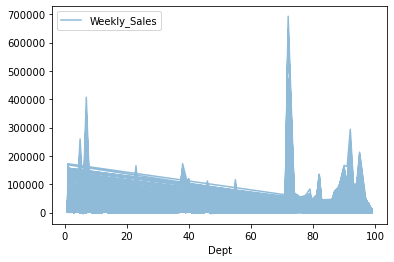

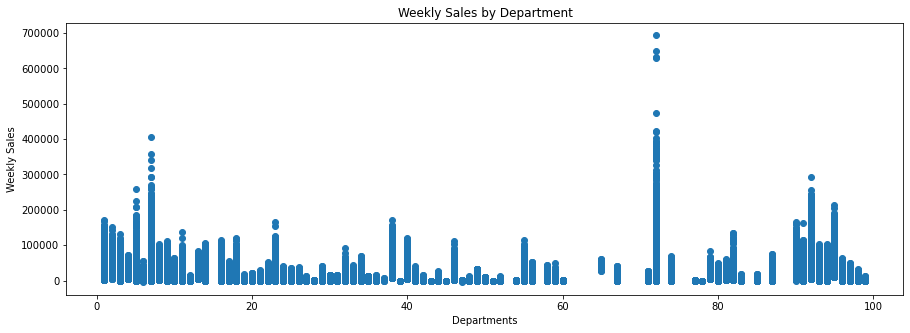

In [14]:
#Sales VS Department
tr.plot(kind='line', x='Dept', y='Weekly_Sales', alpha=1.5,fig=(15,5))

x = tr['Dept']
y = tr['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

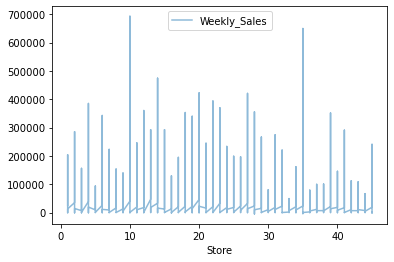

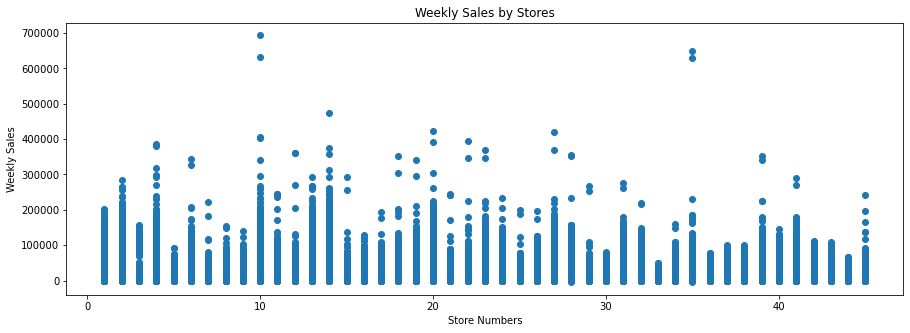

In [15]:
tr.plot(kind='line', x='Store', y='Weekly_Sales', alpha=0.5)

x = tr['Store']
y = tr['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Stores')
plt.xlabel('Store Numbers')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

<AxesSubplot:xlabel='Type', ylabel='Weekly_Sales'>

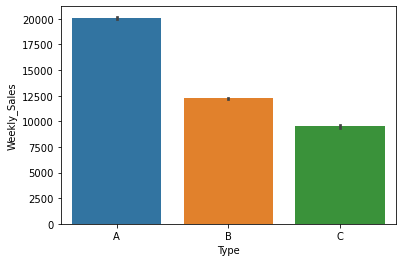

In [16]:
sns.barplot(x=tr["Type"],y=tr["Weekly_Sales"])

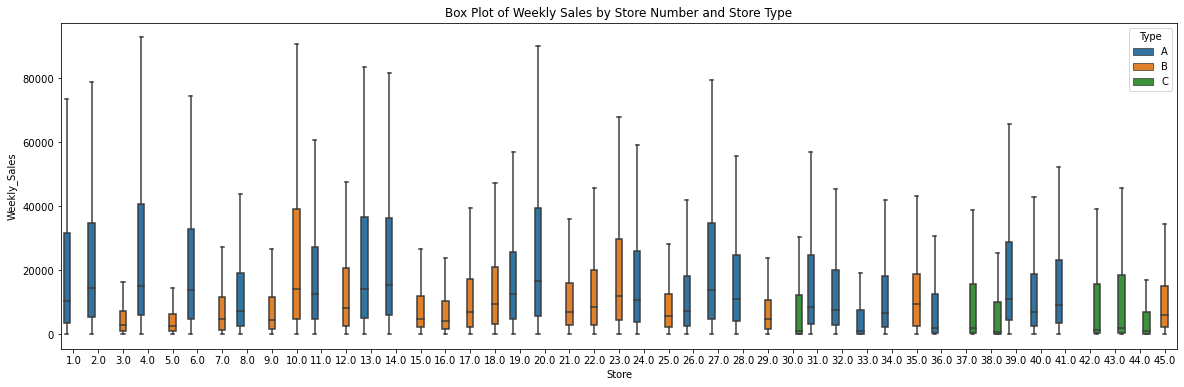

In [17]:
tr_stores = tr.merge(stores, on='Store', how='inner')
# There are negative values present in Weekly sales which are absurd because sales cannot be negative.
tr_stores= tr_stores[tr_stores['Weekly_Sales'] > 0]
#Plot of Weekly Sales by Store Number and Store Type.
d1 = pd.concat([tr_stores['Store'], tr_stores['Weekly_Sales'], tr['Type']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Store Number and Store Type')
fig = sns.boxplot(x='Store', y='Weekly_Sales', data=d1, showfliers=False, hue='Type')

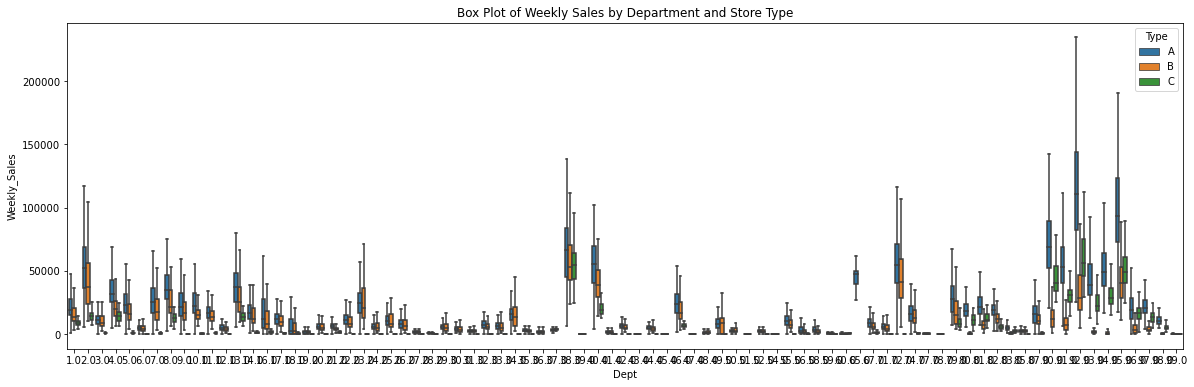

In [18]:
d2 = pd.concat([tr_stores['Dept'], tr_stores['Weekly_Sales'], tr['Type']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Department and Store Type')
fig = sns.boxplot(x='Dept', y='Weekly_Sales', data=d2, showfliers=False, hue='Type')

<AxesSubplot:xlabel='IsHoliday', ylabel='Weekly_Sales'>

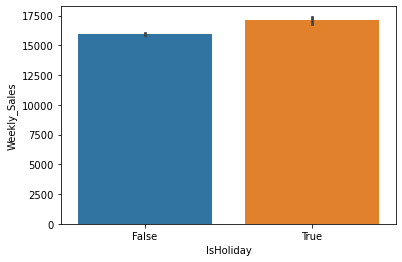

In [19]:
holiday = tr_stores['Weekly_Sales'].loc[tr_stores['IsHoliday']== True] 
non_holiday = tr_stores['Weekly_Sales'].loc[tr_stores['IsHoliday']== False] 
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=tr_stores)

In [20]:
# Form Date, Year, Month, Week, Day and No. of days.
tr_stores['Date'] = pd.to_datetime(tr_stores['Date'])
tr_stores['Year'] = tr_stores['Date'].dt.year
tr_stores['Month']= tr_stores['Date'].dt.month
tr_stores['Week'] = tr_stores['Date'].dt.week
tr_stores['Day']  = tr_stores['Date'].dt.day
tr_stores['No. of days'] = (tr_stores['Date'].dt.date - tr_stores['Date'].dt.date.min()).apply(lambda x:x.days)

Year        = pd.Series(tr_stores['Year'].unique())
Week        = pd.Series(tr_stores['Week'].unique())
Month       = pd.Series(tr_stores['Month'].unique())
Day         = pd.Series(tr_stores['Day'].unique())
No_of_days  = pd.Series(tr_stores['No. of days'].unique())

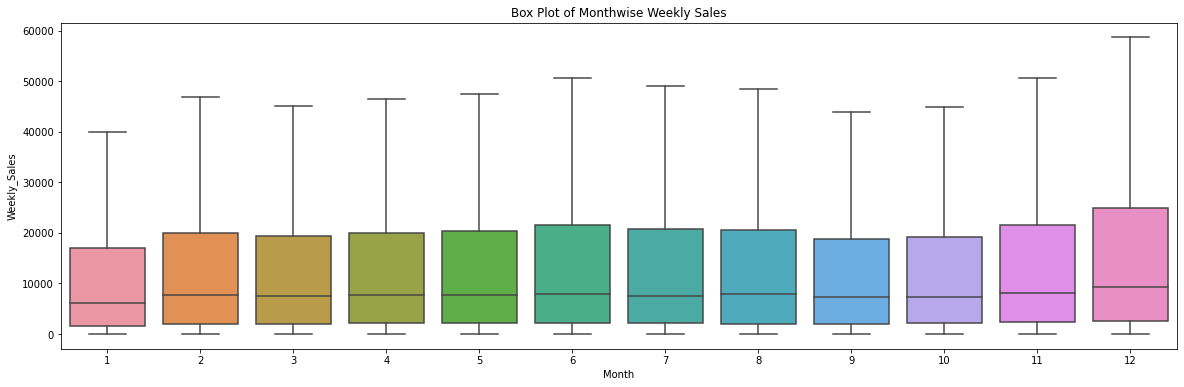

In [21]:
d3 = pd.concat([tr_stores['Month'], tr_stores['Weekly_Sales']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Monthwise Weekly Sales')
fig = sns.boxplot(x='Month', y='Weekly_Sales', data=d3, showfliers=False)

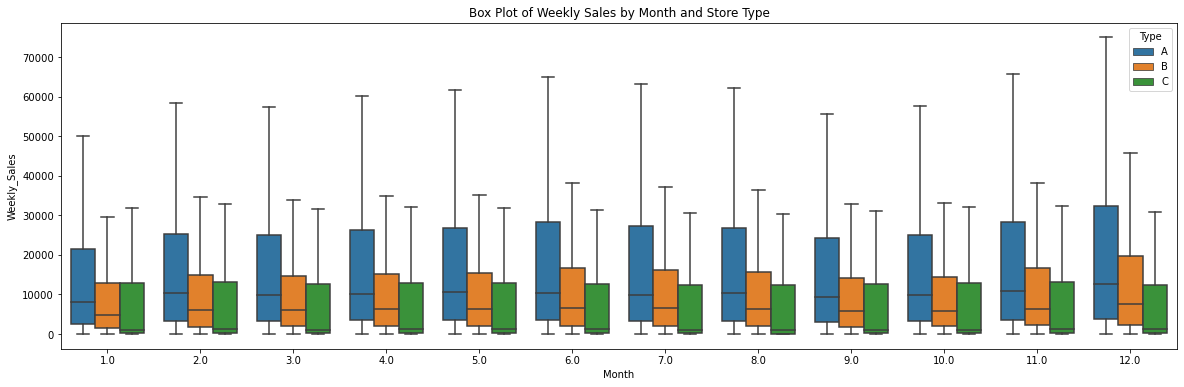

In [22]:
d4 = pd.concat([tr_stores['Month'], tr_stores['Weekly_Sales'], tr['Type']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Month and Store Type')
fig = sns.boxplot(x='Month', y='Weekly_Sales', data=d4, showfliers=False, hue='Type')

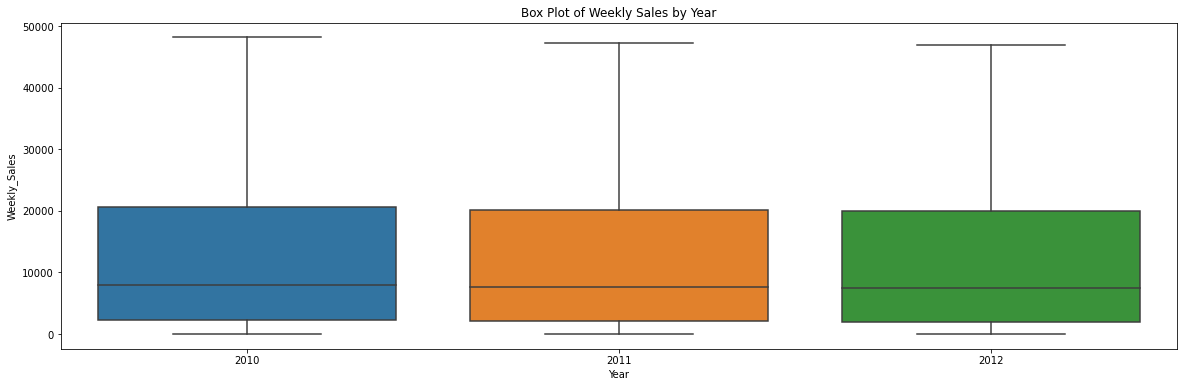

In [23]:
d5 = pd.concat([tr_stores['Year'], tr_stores['Weekly_Sales']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Year')
fig = sns.boxplot(x='Year', y='Weekly_Sales', data=d5, showfliers=False)

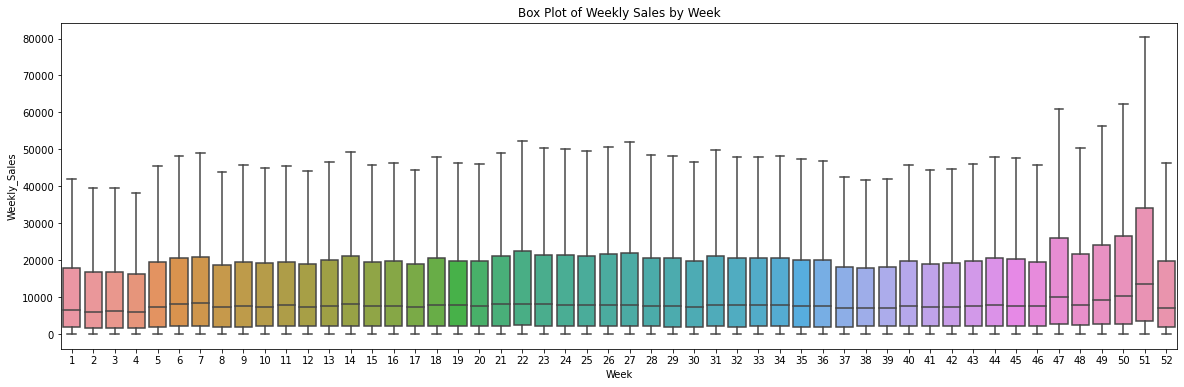

In [24]:
d6 = pd.concat([tr_stores['Week'], tr_stores['Weekly_Sales']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Week')
fig = sns.boxplot(x='Week', y='Weekly_Sales', data=d6, showfliers=False)

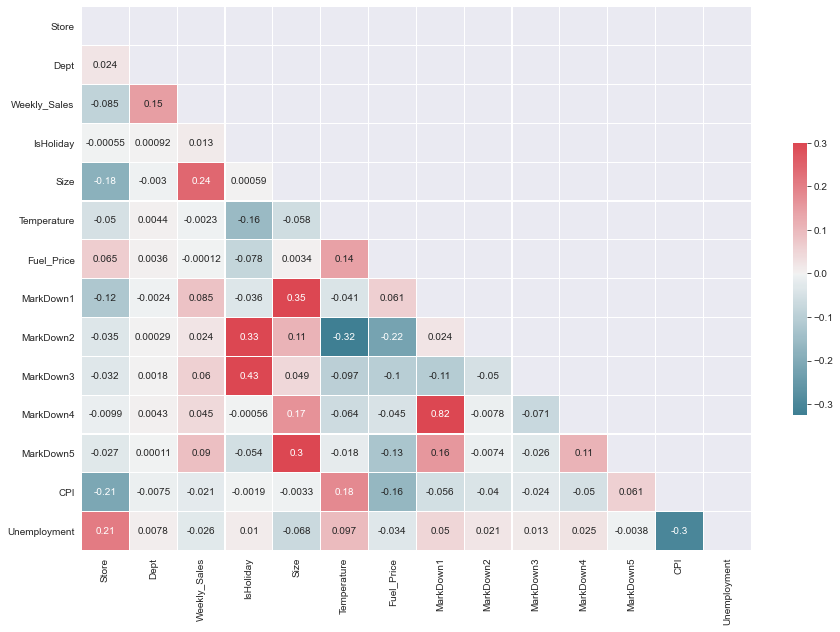

In [25]:
sns.set_style('dark')
corr = tr.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f,ax = plt.subplots(figsize=(15,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            linewidths=.2, cbar_kws={"shrink": .5})

In [26]:
#Missing Value Treatment
print (tr.isnull().sum())

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64


In [27]:
te['CPI']=te.groupby(['Dept'])['CPI'].transform(lambda x: x.fillna(x.mean()))
te['Unemployment']=te.groupby(['Dept'])['Unemployment'].transform(lambda x: x.fillna(x.mean()))

In [28]:
tr=tr.fillna(0)
te=te.fillna(0)

In [29]:
print (tr.isnull().sum())

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64


In [30]:
tr.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


In [31]:
#Feature Extraction # Date feature
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     421570 non-null  float64
 10  MarkDown2     421570 non-null  float64
 11  MarkDown3     421570 non-null  float64
 12  MarkDown4     421570 non-null  float64
 13  MarkDown5     421570 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 71.9+ MB


In [32]:
tr['Date'] = pd.to_datetime(tr['Date'])
te['Date'] = pd.to_datetime(te['Date'])

In [33]:
# Extract date features
tr['week'] =tr['Date'].dt.week
tr['month'] =tr['Date'].dt.month 
tr['year'] =tr['Date'].dt.year
tr['day'] =tr['Date'].dt.day 

te['week'] =te['Date'].dt.week
te['month'] =te['Date'].dt.month 
te['year'] =te['Date'].dt.year
te['day'] =te['Date'].dt.day 

In [34]:
print (tr.Type.value_counts())
print ("*"*30)
print (te.Type.value_counts())

A    215478
B    163495
C     42597
Name: Type, dtype: int64
******************************
A    58713
B    44500
C    11851
Name: Type, dtype: int64


In [35]:
print (tr.IsHoliday.value_counts())
print ("*"*30)
print (te.IsHoliday.value_counts())

False    391909
True      29661
Name: IsHoliday, dtype: int64
******************************
False    106136
True       8928
Name: IsHoliday, dtype: int64


In [36]:
tr_te_data = [tr, te]

In [37]:
#type mapping
tm = {"A": 1, "B": 2, "C": 3}
for data in tr_te_data:
    data['Type'] = data['Type'].map(tm)

In [38]:
tm = {False: 0, True: 1}
for data in tr_te_data:
    data['IsHoliday'] = data['IsHoliday'].map(tm)

In [39]:
#Making new holidays based on given data
tr['Super_Bowl'] = np.where((tr['Date']==datetime(2010, 2, 12)) | (tr['Date']==datetime(2011, 2, 11)) | (tr['Date']==datetime(2012, 2, 10)) | (tr['Date']==datetime(2013, 2, 8)),1,0)
tr['Labour_Day'] = np.where((tr['Date']==datetime(2010, 9, 10)) | (tr['Date']==datetime(2011, 9, 9)) | (tr['Date']==datetime(2012, 9, 7)) | (tr['Date']==datetime(2013, 9, 6)),1,0)
tr['Thanksgiving'] = np.where((tr['Date']==datetime(2010, 11, 26)) | (tr['Date']==datetime(2011, 11, 25)) | (tr['Date']==datetime(2012, 11, 23)) | (tr['Date']==datetime(2013, 11, 29)),1,0)
tr['Christmas'] = np.where((tr['Date']==datetime(2010, 12, 31)) | (tr['Date']==datetime(2011, 12, 30)) | (tr['Date']==datetime(2012, 12, 28)) | (tr['Date']==datetime(2013, 12, 27)),1,0)
#........................................................................
te['Super_Bowl'] = np.where((te['Date']==datetime(2010, 2, 12)) | (te['Date']==datetime(2011, 2, 11)) | (te['Date']==datetime(2012, 2, 10)) | (te['Date']==datetime(2013, 2, 8)),1,0)
te['Labour_Day'] = np.where((te['Date']==datetime(2010, 9, 10)) | (te['Date']==datetime(2011, 9, 9)) | (te['Date']==datetime(2012, 9, 7)) | (te['Date']==datetime(2013, 9, 6)),1,0)
te['Thanksgiving'] = np.where((te['Date']==datetime(2010, 11, 26)) | (te['Date']==datetime(2011, 11, 25)) | (te['Date']==datetime(2012, 11, 23)) | (te['Date']==datetime(2013, 11, 29)),1,0)
te['Christmas'] = np.where((te['Date']==datetime(2010, 12, 31)) | (te['Date']==datetime(2011, 12, 30)) | (te['Date']==datetime(2012, 12, 28)) | (te['Date']==datetime(2013, 12, 27)),1,0)


In [40]:
# Altering the isHoliday value depending on these new holidays...
tr['IsHoliday']=tr['IsHoliday']|tr['Super_Bowl']|tr['Labour_Day']|tr['Thanksgiving']|tr['Christmas']
te['IsHoliday']=te['IsHoliday']|te['Super_Bowl']|te['Labour_Day']|te['Thanksgiving']|te['Christmas']

In [41]:
print (tr.Christmas.value_counts())
print (tr.Super_Bowl.value_counts())
print (tr.Thanksgiving.value_counts())
print (tr.Labour_Day.value_counts())

0    415624
1      5946
Name: Christmas, dtype: int64
0    412675
1      8895
Name: Super_Bowl, dtype: int64
0    415611
1      5959
Name: Thanksgiving, dtype: int64
0    412709
1      8861
Name: Labour_Day, dtype: int64


In [42]:
dp=['Super_Bowl','Labour_Day','Thanksgiving','Christmas']
tr.drop(dp,axis=1,inplace=True)
te.drop(dp,axis=1,inplace=True)

In [43]:
#feature Selection
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  int64         
 5   Type          421570 non-null  int64         
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     421570 non-null  float64       
 10  MarkDown2     421570 non-null  float64       
 11  MarkDown3     421570 non-null  float64       
 12  MarkDown4     421570 non-null  float64       
 13  MarkDown5     421570 non-null  float64       
 14  CPI           421570 non-null  float64       
 15  Unemployment  421

In [44]:
#Dropping irrevelant variables
features_drop=['Unemployment','CPI','MarkDown5']
tr=tr.drop(features_drop, axis=1)
te=te.drop(features_drop, axis=1)

In [45]:
tr.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,week,month,year,day
0,1,1,2010-02-05,24924.50,0,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,5,2,2010,5
1,1,2,2010-02-05,50605.27,0,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,5,2,2010,5


In [46]:
#### train X= Exery thing except Weekly_Sales
X_tr=tr.drop(['Weekly_Sales','Date'], axis=1)
#### train Y= Only Weekly_Sales 
y_tr=tr['Weekly_Sales'] 
X_te=te.drop('Date',axis=1).copy()
X_tr.shape, y_tr.shape, X_te.shape

((421570, 15), (421570,), (115064, 15))

In [47]:
#Linear Regression

LR = LinearRegression(normalize=True)
LR.fit(X_tr,y_tr)
pred_lr=LR.predict(X_te)
LRS = (LR.score(X_tr,y_tr))
print('Linear Regression Accuracy = ',LRS)

Linear Regression Accuracy =  0.08649937858980028


In [48]:
LR = LinearRegression(normalize=True)
LR.fit(X_tr,y_tr)
p=LR.predict(X_tr)
LR_MAE = metrics.mean_absolute_error(y_tr, p)
LR_MSE = np.sqrt(metrics.mean_squared_error(y_tr, p))
LR_R2S = r2_score(y_tr, p)
print('Mean Absolute Error:', LR_MAE)    
print('Mean Squared Error:', LR_MSE)
print("R-squared Score:",LR_R2S)

Mean Absolute Error: 14561.291231756028
Mean Squared Error: 21706.69355436955
R-squared Score: 0.08649937858980028


In [49]:
#Decision Tree Regressor

DT = DecisionTreeRegressor()
DT.fit(X_tr, y_tr)
pred_dt=DT.predict(X_te)
DTS= DT.score(X_tr,y_tr)
print('Decision Tree Regression Accuracy = ',DTS)

Decision Tree Regression Accuracy =  1.0


In [50]:
DT = DecisionTreeRegressor(max_depth=5,random_state=0)
DT.fit(X_tr, y_tr)
p=DT.predict(X_tr)
DT_MAE = metrics.mean_absolute_error(y_tr, p)
DT_MSE = np.sqrt(metrics.mean_squared_error(y_tr, p))
DT_R2S = r2_score(y_tr, p)
print('Mean Absolute Error:', DT_MAE)    
print('Mean Squared Error:', DT_MSE)
print("R-squared Score:",DT_R2S)

Mean Absolute Error: 9496.815428127362
Mean Squared Error: 15389.969519942144
R-squared Score: 0.540805141944975


In [51]:
#Random Forest

RF = RandomForestRegressor()
RF.fit(X_tr,y_tr)
pred_rf=RF.predict(X_te)
RFS= RF.score(X_tr,y_tr)
print('Random Forest Regression Accuracy= ',RFS)

Random Forest Regression Accuracy=  0.997090659539677


In [52]:
RF = RandomForestRegressor(max_depth=5,n_estimators=20, random_state=0)
RF.fit(X_tr,y_tr)
p=RF.predict(X_tr)
RF_MAE = metrics.mean_absolute_error(y_tr, p)
RF_MSE = np.sqrt(metrics.mean_squared_error(y_tr, p))
RF_R2S = r2_score(y_tr, p)
print('Mean Absolute Error:', RF_MAE)    
print('Mean Squared Error:', RF_MSE)
print("R-squared Score:",RF_R2S)

Mean Absolute Error: 9202.016292702083
Mean Squared Error: 14887.941755759091
R-squared Score: 0.5702748032800993


In [53]:
#Gradient booster

GB = GradientBoostingRegressor()
GB.fit(X_tr,y_tr)
pred_gb=GB.predict(X_te)
GBS =GB.score(X_tr,y_tr)
print('Gradient Booster Regression Accuracy =',GBS)

Gradient Booster Regression Accuracy = 0.7372249133256881


In [54]:
GB = GradientBoostingRegressor()
GB.fit(X_tr,y_tr)
p=GB.predict(X_tr)
GB_MAE = metrics.mean_absolute_error(y_tr, p)
GB_MSE = np.sqrt(metrics.mean_squared_error(y_tr, p))
GB_R2S = r2_score(y_tr, p)
print('Mean Absolute Error:', GB_MAE)    
print('Mean Squared Error:', GB_MSE)
print("R-squared Score:",GB_R2S)

Mean Absolute Error: 6972.354494802751
Mean Squared Error: 11642.100541920665
R-squared Score: 0.737224913325688


In [55]:
model = pd.DataFrame({
    'Model Name': ['Linear Regression','Decision Tree Regression','Random Forest Regression','Gradient Boost Regressor'],
    'Mean Absolute Error': [LR_MAE,DT_MAE,RF_MAE,GB_MAE],
    'Mean Squared Error': [LR_MSE,DT_MSE,RF_MSE,GB_MSE],
    'R-squared Score': [LR_R2S,DT_R2S,RF_R2S,GB_R2S]
    })
Index = pd.Series([1, 2, 3, 4])
model.set_index(Index, inplace=True)
model

,Model Name,Mean Absolute Error,Mean Squared Error,R-squared Score
1,Linear Regression,14561.291232,21706.693554,0.086499
2,Decision Tree Regression,9496.815428,15389.969520,0.540805
3,Random Forest Regression,9202.016293,14887.941756,0.570275
4,Gradient Boost Regressor,6972.354495,11642.100542,0.737225


In [56]:
models = pd.DataFrame({
    'Model Name': ['Linear Regression','Decision Tree Regression','Random Forest Regression','Gradient Boost Regressor'],
    'Accuracy Score': [LRS, DTS, RFS, GBS]
    })
Index = pd.Series([1, 2, 3, 4])
models.set_index(Index, inplace=True)
models

,Model Name,Accuracy Score
1,Linear Regression,0.086499
2,Decision Tree Regression,1.000000
3,Random Forest Regression,0.997091
4,Gradient Boost Regressor,0.737225


<AxesSubplot:>

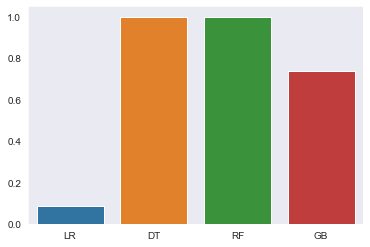

In [57]:
x=['LR','DT','RF','GB']
y=[LRS, DTS, RFS,GBS]
sns.barplot(x,y)

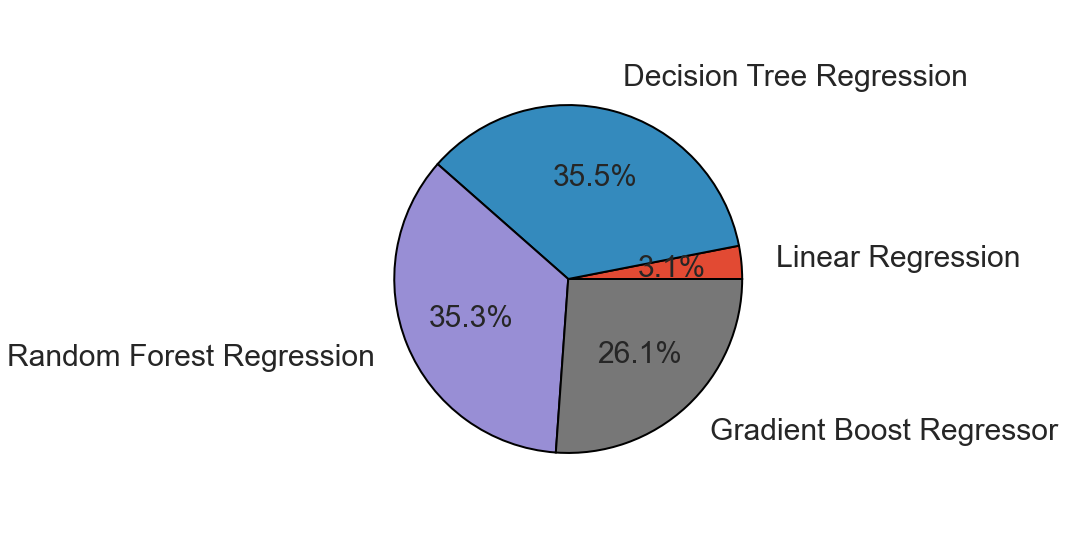

In [58]:
sorted_type = stores.groupby('Type')
#Make Pie chart for Stores including Weekly Sales.
plt.style.use('ggplot')
labels=['Linear Regression','Decision Tree Regression','Random Forest Regression','Gradient Boost Regressor']
sizes=sorted_type.describe()['Size'].round(1)
sizes=[(LRS/(LRS + DTS + RFS+ GBS))*100,
       (DTS/(LRS + DTS + RFS+ GBS))*100,
       (RFS/(LRS + DTS + RFS+ GBS))*100,
       (GBS/(LRS + DTS + RFS+ GBS))*100] 
fig, axes = plt.subplots(1,1, figsize=(10,10))

wprops={'edgecolor':'black',
      'linewidth':2}

tprops = {'fontsize':30}

axes.pie(sizes,
        labels=labels,
        explode=(0.0,0,0,0),
        autopct='%1.1f%%',
        pctdistance=0.6,
        labeldistance=1.2,
        wedgeprops=wprops,
        textprops=tprops,
        radius=0.8,
        center=(0.5,0.5))
plt.show()

In [59]:
# Prediction Sales
submission = pd.DataFrame({
        "Store": test.Store.astype(str),
        "Dept": test.Dept.astype(str),
        " Date ": test.Date.astype(str),
        "Weekly_Sales": pred_rf,
        "Weekly_Sales": pred_dt
    })

submission.to_csv('weekly_sales predicted.csv', index=False)
submission.to_excel(writer,'Weekly_sales Pred',index=False)

In [60]:
submission.head()

,Store,Dept,Date,Weekly_Sales
0,1,1,2012-11-02,25051.36
1,1,1,2012-11-09,49439.58
2,1,1,2012-11-16,11676.98
3,1,1,2012-11-23,41305.39
4,1,1,2012-11-30,32700.34
